## phase shift identification 

refs: 

https://stackoverflow.com/a/27546385/9357244

https://stackoverflow.com/a/6157997/9357244

FFT https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html 


# Test signals 

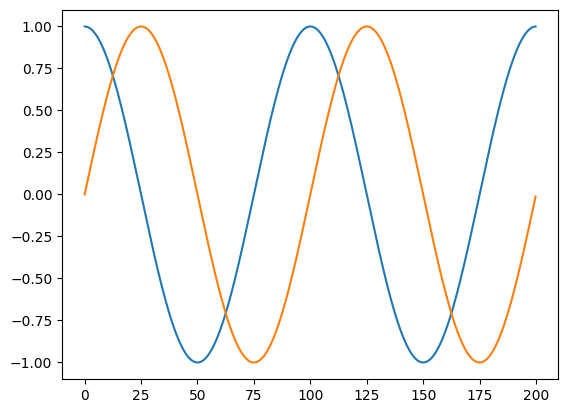

In [57]:
import numpy as np
import matplotlib.pyplot as plt 

frq = 0.01  # [Hz]
ncycles = 20
nsamples = 1000
phase_lag = - np.pi  / 2
maxtime = 200 # ncycles / f

t = np.linspace(0, maxtime, nsamples, endpoint=False)

a = np.cos(2 * np.pi * frq * t)
b = np.cos(2 * np.pi * frq * t + phase_lag)

plt.plot(t, a)
plt.plot(t, b)

# Cross-correlation

for real-valued, discrete signals: 

In [75]:
np.sum(a * b)

2.1316282072803006e-14

shift the two arrays to find where it maximizes correlation

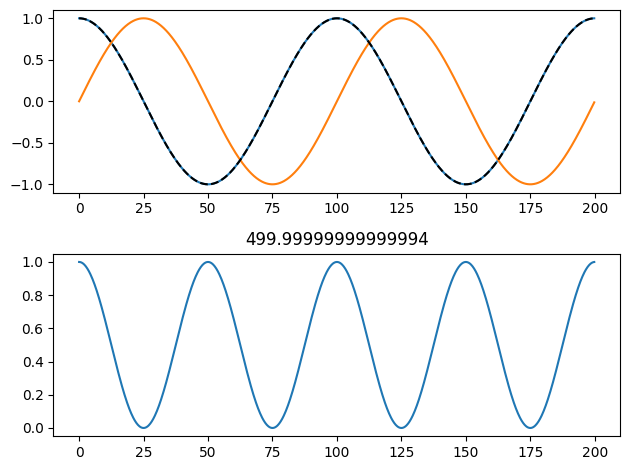

In [101]:
shift = -125
shifted = np.roll(b, shift)

f, axs = plt.subplots(nrows=2, ncols = 1)
axs[0].plot(t, a)
axs[0].plot(t, b)
axs[0].plot(t, shifted, '--k')
plt.title(np.sum(a * shifted))

axs[1].plot(t, a * shifted)
f.set_tight_layout('tight')

could do it manually, but scipy will be faster

(-118, -1.4828317324943825, -1.5707963267948966, 0.05599999999999991)


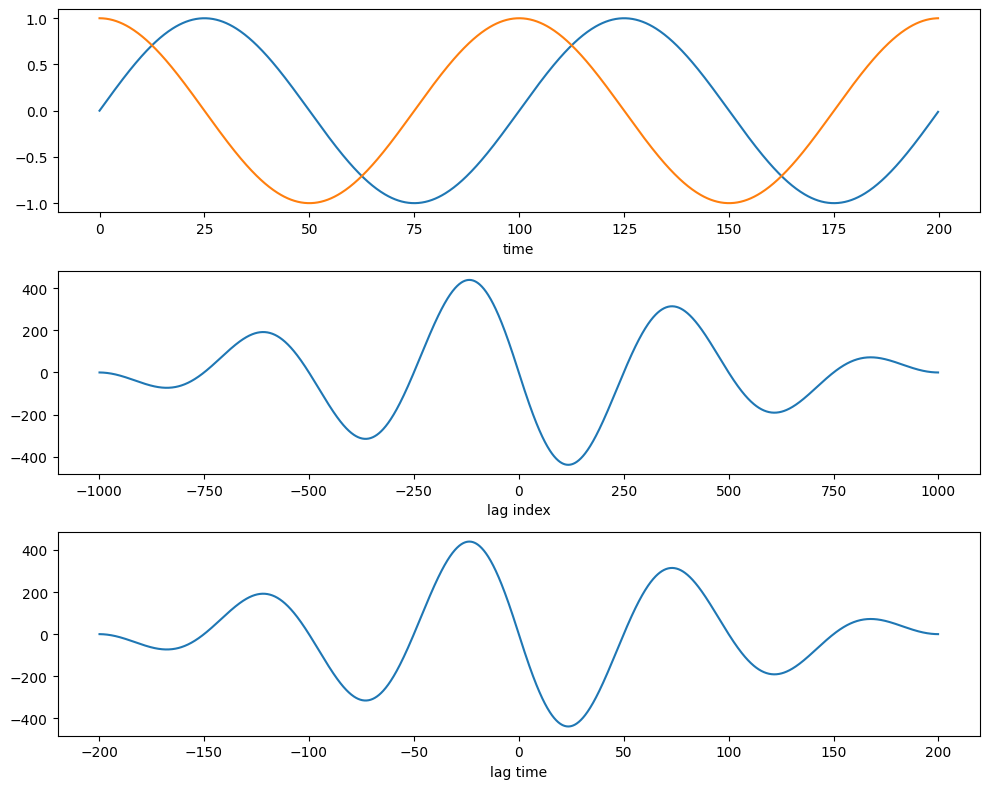

In [96]:
from scipy import signal

c = signal.correlate(a, b)
lags = signal.correlation_lags(a.size, b.size)  # lag indeces used for tasting

dt = t[1] - t[0]
lags_time = lags * dt 
lag_index = lags[np.argmax(c)] # the lag_index that maximizes correlation
timeshift =  lag_index / lags.max() * t[-1]  # absolute timeshift
phase_shift = 2*np.pi* frq * timeshift 

err = np.abs((phase_lag - phase_shift)/phase_lag)
print((lag_index, phase_shift, phase_lag, err))

f, axs = plt.subplots(nrows =3 , ncols = 1, figsize=(10,8))

axs[0].plot(t, b)
axs[0].plot(t, a)
axs[0].set_xlabel('time')
axs[1].plot(lags, c) 
axs[1].set_xlabel("lag index") 

axs[2].plot(lags_time, c)
axs[2].set_xlabel("lag time") 

f.set_tight_layout('tight')

### problems

accuracy depends on the number of sample points and the number of cycles contained in the sample 

## Fourier Transforms 

## Wavelet Analysis 